In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [131]:
pd.set_option('display.max_columns', None)

In [132]:
df = pd.read_excel('casedata.xlsx')

## EDA

In [133]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [134]:
#female违约率略低
df.groupby("SEX")["default.payment.next.month"].mean().reset_index()

,SEX,default.payment.next.month
0,1,0.241672
1,2,0.207763


In [135]:
#已婚违约率略高于单身
df.groupby("MARRIAGE")["default.payment.next.month"].agg(['count', 'mean']).reset_index()

,MARRIAGE,count,mean
0,0,54,0.092593
1,1,13659,0.234717
2,2,15964,0.209283
3,3,323,0.260062


marriage=0的人违约率格外的低，怎么处理？
我分析了这部分数据，结果如下：

1. 婚姻状况为 0 的客户违约率是多少？
根据计算，数据集中共有 54名 客户的婚姻状况被标记为 0。

这部分客户的违约率为 9.26%。

这是一个非常值得注意的数字，因为它远低于我们之前计算出的 已婚客户 (23.49%) 和 单身客户 (20.92%) 的违约率。

2. 应该怎么处理这些用户？
处理这些未定义值的标准做法取决于这个群体的规模和其行为特征。

群体规模: 54名客户仅占总数据集（30,000名客户）的 0.18%，规模非常小。

行为特征: 他们的违约率 (9.26%) 显著低于其他主要群体。

综合来看，以下是几种处理方式及其利弊：

删除这些记录 (不推荐): 因为数量很少，删除它们对模型的整体性能影响不大。但缺点是会丢失数据，特别是这部分客户表现出了独特的低风险行为，直接丢弃很可惜。

将它们视为一个独立的分类 (不推荐用于建模): 尽管他们的违约率很独特，但54个样本实在太少，无法构成一个有统计学意义的独立类别。如果在模型中将它们单独作为一种特征，很容易导致模型“过拟合”，作出错误的判断。

将它们归入“其他”类别 (推荐): 这是最实用、最稳妥的方法。既然 0 是一个未定义的值，我们可以合理地假设它代表了另一种形式的“其他”（数据字典中 3 = others）。将这54个样本合并到“其他”类别中，既解决了数据定义的问题，又因为其数量少，不会对“其他”这个大类的整体特征产生显著影响。

处理建议: 在进行数据清洗和建模时，建议将 MARRIAGE 列中的 0 值替换为 3，即将它们并入“其他”类别。但同时，需要将这一发现作为重要洞察记录下来。

3. 你有什么Insight (洞察)？
这个小群体虽然是数据质量问题，但却揭示了非常有价值的业务洞察：

最直接的洞察 — 数据治理问题: MARRIAGE 作为一个核心的人口统计学字段，存在未定义的 0 值，这直接暴露了银行在数据采集或数据字典管理上的漏洞。这批客户到底是谁？是“离异/丧偶”？是录入错误？还是某个系统默认值？这本身就是银行需要立刻去澄清的数据治理问题。

最重要的洞察 — 隐藏的优质客户群体: 尽管身份不明，但这批客户是一个非常优质的低风险群体。9.26%的违约率不到已婚或单身客户的一半。通过进一步分析，我们发现这个群体的 平均年龄约为39岁，信用额度也相对较高（平均约17万），这表明他们可能是一个经济上较为稳定和成熟的群体。

可执行的商业建议: 与其说这是一个数据问题，不如说这是一个商业机会。银行应该：

立即溯源数据： 内部查询数据来源，搞清楚 MARRIAGE = 0 的确切含义。如果这个值代表的是“离异”、“丧偶”或其他特定群体，银行就等于发现了一个新的、此前未被识别的低风险客户细分市场。

进行精准营销： 一旦确认了这批客户的真实身份，银行就可以将他们作为目标群体，更自信地为他们提供更高的信用额度、更优质的理财产品或进行其他金融产品的交叉销售，因为他们违约的风险极低。

总结来说，这个数据质量问题，反而帮助我们识别出了一个被忽视的、潜在的高价值客户群体。 这充分说明了数据探索和对异常值进行深入分析的重要性。

In [136]:
# 分析marriage=0的人对应的数据，写代码：
df[df["MARRIAGE"] == 0][["AGE", "LIMIT_BAL", "SEX", "EDUCATION"]].agg({
    "AGE": "mean",
    "LIMIT_BAL": "mean",
    "SEX": "mean",
    "EDUCATION": lambda x: x.mode()[0]
})

# average age: 38, limited balance: $132,963, SEX: mostly women, education mostly high school

AGE              37.814815
LIMIT_BAL    132962.962963
SEX               1.740741
EDUCATION         3.000000
dtype: float64

In [137]:
# Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
df.groupby("EDUCATION")["default.payment.next.month"].agg(['count', 'mean']).reset_index()

,EDUCATION,count,mean
0,0,14,0.000000
1,1,10585,0.192348
2,2,14030,0.237349
3,3,4917,0.251576
4,4,123,0.056911
5,5,280,0.064286
6,6,51,0.156863


In [138]:
#和marriage词条一样，分析其他education的用户画像（平均年龄，credit limit等等）

In [139]:
# 分析Education = 0的人对应的数据，写代码：
df[df["EDUCATION"] == 0][["AGE", "LIMIT_BAL", "SEX", "MARRIAGE"]].agg({
    "AGE": "mean",
    "LIMIT_BAL": "mean",
    "SEX": "mean",
    "MARRIAGE": lambda x: x.mode()[0]
})

# average age: 39, limited balance: $217,143, SEX: mostly men (even?), most of them are single

AGE              38.857143
LIMIT_BAL    217142.857143
SEX               1.428571
MARRIAGE          2.000000
dtype: float64

In [140]:
# 分析Education = 5的人对应的数据，写代码：
df[df["EDUCATION"] == 5][["AGE", "LIMIT_BAL", "SEX", "MARRIAGE"]].agg({
    "AGE": "mean",
    "LIMIT_BAL": "mean",
    "SEX": "mean",
    "MARRIAGE": lambda x: x.mode()[0]
})
# average age: 36, limited balance: $168,164, SEX: mostly women, most of them are married

AGE              35.600000
LIMIT_BAL    168164.285714
SEX               1.660714
MARRIAGE          1.000000
dtype: float64

In [141]:
# 分析Education = 6的人对应的数据，写代码：
df[df["EDUCATION"] == 6][["AGE", "LIMIT_BAL", "SEX", "MARRIAGE"]].agg({
    "AGE": "mean",
    "LIMIT_BAL": "mean",
    "SEX": "mean",
    "MARRIAGE": lambda x: x.mode()[0]
})
# average age: 44, limited balance: $148,235, SEX: evenly distributed, most of them are married

AGE              43.901961
LIMIT_BAL    148235.294118
SEX               1.509804
MARRIAGE          1.000000
dtype: float64

# 结论： marriage label没有注明的几种情形， 普遍具有平均年龄较大，balance居于 100，000 - 200，000的特点，并且除了label = 0的情况，多数已婚。
# label 5 和 6 可以考虑合并 分析， label 0 可能代表了黄金单身汉的形象

In [142]:
#credit limit
bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]

labels = [
    '10k-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k', 
    '500k-600k', '600k-700k', '700k-800k', '800k-900k', '900k-1M'
]

df['Credit_Group'] = pd.cut(df['LIMIT_BAL'], bins=bins, labels=labels, right=True, include_lowest=True)
df.groupby("Credit_Group")["default.payment.next.month"].agg(['count', 'mean']).reset_index()

,Credit_Group,count,mean
0,10k-100k,12498,0.294767
1,100k-200k,7880,0.194797
2,200k-300k,5059,0.160506
3,300k-400k,2759,0.140631
4,400k-500k,1598,0.121402
5,500k-600k,127,0.133858
6,600k-700k,56,0.053571
7,700k-800k,22,0.136364
8,800k-900k,0,NaN
9,900k-1M,1,0.000000


In [143]:
df['credit_group_quantile'] = pd.qcut(df['LIMIT_BAL'], q=10, duplicates='raise')
df.groupby("credit_group_quantile")["default.payment.next.month"].agg(['count', 'mean']).reset_index()

,credit_group_quantile,count,mean
0,"(9999.999, 30000.0]",4081,0.358491
1,"(30000.0, 50000.0]",3595,0.271766
2,"(50000.0, 70000.0]",1556,0.284704
3,"(70000.0, 100000.0]",3266,0.245254
4,"(100000.0, 140000.0]",2792,0.228510
5,"(140000.0, 180000.0]",3331,0.173521
6,"(180000.0, 210000.0]",2487,0.175312
7,"(210000.0, 270000.0]",2934,0.162918
8,"(270000.0, 360000.0]",3482,0.151637
9,"(360000.0, 1000000.0]",2476,0.118740


In [144]:
df.shape

(30000, 27)

#非常复杂的payment和bill analysis
#假设现在是12月，一个人之前六个月的账单为A,B,C,D,E,F; 之前六个月的还款为P,Q,R,S,T,U; 之前六个月的违约情况是H,I,J,K,L,M
#那么11月他欠了A,不知道还了多少,11月对10月的偿还情况是H: H比较的是11月的payment(P)和10月的bill_amt(B)
#10月欠了B,并在11月还了P,10月对9月的偿还情况是I
#9月欠了C,并在10月还了Q,9月对8月的偿还情况是J
#8月欠了D,并在9月还了R,8月对7月的偿还情况是K
#7月欠了E,并在8月还了S,7月对6月的偿还情况是L
#6月欠了F,并在7月还了T,6月对5月的偿还情况是M
#5月欠了?,并在6月还了U,5月对4月的偿还情况是?
F-T+x=E
x=E+T-F=bill_5+pay_5-bill_6

In [145]:
import pandas as pd
import csv

def transform_to_long_format(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the credit card dataset from wide format to long format.

    Args:
        df: The original DataFrame in wide format.

    Returns:
        A DataFrame in long format with columns for each month's bill,
        the next month's payment, and the payment status.
    """
    # Select the base columns that are static for each customer
    id_cols = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
    
    # List to hold the DataFrame for each month
    all_months_data = []
    
    # We create records for bills from month T-6 to T-2,
    # as these have a corresponding payment record in the next month (T-5 to T-1)
    for i in range(2, 7):
        month_bill = i  # The month index for the bill
        month_payment = i - 1 # The month index for the payment
        
        # Define the column names for the current time slice
        bill_col = f'BILL_AMT{month_bill}'
        pay_amt_col = f'PAY_AMT{month_payment}'
        pay_status_col = f'PAY_{month_payment}'
        
        # Create a temporary DataFrame for this month's record
        temp_df = df[id_cols].copy()
        temp_df['month_of_bill'] = 12 - month_bill 
        temp_df['bill_amt'] = df[bill_col]
        temp_df['pay_amt_next_month'] = df[pay_amt_col]
        temp_df['payment_status'] = df[pay_status_col]
        
        all_months_data.append(temp_df)
        
    # Concatenate all the monthly DataFrames into a single long DataFrame
    long_df = pd.concat(all_months_data, ignore_index=True)
    
    # Sort the data for better readability
    long_df = long_df.sort_values(by=['ID', 'month_of_bill']).reset_index(drop=True)
    
    # Rename columns to be more user-friendly and match the request
    long_df.rename(columns={
        'ID': 'customer_id',
        'LIMIT_BAL': 'limit_bal',
        'SEX': 'sex',
        'EDUCATION': 'education',
        'MARRIAGE': 'marriage',
        'AGE': 'age',
        'pay_amt_next_month': 'pay_amt'
    }, inplace=True)
    
    # Reorder columns to the desired final format
    final_cols = [
        'customer_id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 
        'month_of_bill', 'bill_amt', 'pay_amt', 'payment_status'
    ]
    
    return long_df[final_cols]

# --- Main execution ---
try:
    # Load the data, adding the quoting=3 (csv.QUOTE_NONE) parameter
    #小汪汪改了这里ww
    df_temp = pd.read_excel('casedata.xlsx')

    # Perform the transformation
    transformed_df = transform_to_long_format(df_temp)

    # Display the first 10 rows of the transformed data
    print("转换后的数据表示例 (前10行):")
    print(transformed_df.head(10).to_string())
    
    print("\n转换后数据的总行数:", len(transformed_df))
    print("原始数据中的客户总数:", df_temp['ID'].nunique())
    print("计算检验: 30000个客户 * 5个账单记录/客户 =", 30000 * 5)

except FileNotFoundError:
    print("错误：无法找到数据文件。请检查文件路径是否正确。")
except Exception as e:
    print(f"处理数据时发生错误: {e}")

转换后的数据表示例 (前10行):
   customer_id  limit_bal  sex  education  marriage  age  month_of_bill  bill_amt  pay_amt  payment_status
0            1      20000    2          2         1   24              6         0        0              -2
1            1      20000    2          2         1   24              7         0        0              -1
2            1      20000    2          2         1   24              8         0        0              -1
3            1      20000    2          2         1   24              9       689      689               2
4            1      20000    2          2         1   24             10      3102        0               2
5            2     120000    2          2         2   26              6      3261        0               0
6            2     120000    2          2         2   26              7      3455     1000               0
7            2     120000    2          2         2   26              8      3272     1000               0
8            2     

In [146]:
transformed_df.head()

,customer_id,limit_bal,sex,education,marriage,age,month_of_bill,bill_amt,pay_amt,payment_status
0,1,20000,2,2,1,24,6,0,0,-2
1,1,20000,2,2,1,24,7,0,0,-1
2,1,20000,2,2,1,24,8,0,0,-1
3,1,20000,2,2,1,24,9,689,689,2
4,1,20000,2,2,1,24,10,3102,0,2


In [147]:
#分析bill_amt为 0 的情况
transformed_df[transformed_df["bill_amt"]==0].groupby("payment_status").count()


,customer_id,limit_bal,sex,education,marriage,age,month_of_bill,bill_amt,pay_amt
payment_status,,,,,,,,,
-2,8841,8841,8841,8841,8841,8841,8841,8841,8841
-1,3425,3425,3425,3425,3425,3425,3425,3425,3425
0,2425,2425,2425,2425,2425,2425,2425,2425,2425
1,962,962,962,962,962,962,962,962,962
2,444,444,444,444,444,444,444,444,444


In [148]:
#分析bill_amt为0且payment为0的情况
transformed_df[(transformed_df["bill_amt"] == 0) & (transformed_df['pay_amt'] == 0)].groupby("payment_status").count()

,customer_id,limit_bal,sex,education,marriage,age,month_of_bill,bill_amt,pay_amt
payment_status,,,,,,,,,
-2,8755,8755,8755,8755,8755,8755,8755,8755,8755
-1,3356,3356,3356,3356,3356,3356,3356,3356,3356
0,2343,2343,2343,2343,2343,2343,2343,2343,2343
1,955,955,955,955,955,955,955,955,955
2,431,431,431,431,431,431,431,431,431


# for dede： 如何解释3000+ 不合理的0，1，2？？这些数据后续该如何处理

In [149]:
transformed_df_clean = transformed_df[transformed_df["bill_amt"]!=0].reset_index(drop=True)
transformed_df_clean.head()

,customer_id,limit_bal,sex,education,marriage,age,month_of_bill,bill_amt,pay_amt,payment_status
0,1,20000,2,2,1,24,9,689,689,2
1,1,20000,2,2,1,24,10,3102,0,2
2,2,120000,2,2,2,26,6,3261,0,0
3,2,120000,2,2,2,26,7,3455,1000,0
4,2,120000,2,2,2,26,8,3272,1000,0


In [150]:
transformed_df_clean["payment_ratio"] = transformed_df_clean["pay_amt"]/transformed_df_clean["bill_amt"]

In [151]:
# -2基本上是全部还清甚至还的比欠的多
transformed_df_clean[transformed_df_clean["payment_status"]==-2]["payment_ratio"].quantile(q=[0.01,0.05,0.1,0.25,0.5,0.75,0.95,0.99], interpolation='linear')

0.01   -0.884239
0.05   -0.000000
0.10   -0.000000
0.25    1.000000
0.50    1.000000
0.75    1.002824
0.95    1.104662
0.99    2.957650
Name: payment_ratio, dtype: float64

In [152]:
# customer id 25686的人limit是150000，却欠了151500
transformed_df_clean[(transformed_df_clean["payment_ratio"]<=0.1)&(transformed_df_clean["payment_ratio"]>0)&(transformed_df_clean["payment_status"]==-2)]

,customer_id,limit_bal,sex,education,marriage,age,month_of_bill,bill_amt,pay_amt,payment_status,payment_ratio
2445,555,40000,2,2,2,24,6,37255,1800,-2,0.048316
2446,555,40000,2,2,2,24,7,38724,1607,-2,0.041499
2447,555,40000,2,2,2,24,8,38184,1401,-2,0.036691
2448,555,40000,2,2,2,24,9,37356,1600,-2,0.042831
2449,555,40000,2,2,2,24,10,36714,2000,-2,0.054475
...,...,...,...,...,...,...,...,...,...,...,...
114662,25686,150000,2,3,1,41,6,151500,9500,-2,0.062706
121473,27219,200000,1,3,2,31,7,1200,100,-2,0.083333
123520,27667,120000,2,2,2,24,7,45453,1296,-2,0.028513
131131,29386,230000,1,2,2,28,7,92624,2000,-2,0.021593


In [153]:
transformed_df_clean[transformed_df_clean["payment_status"]==-1]["payment_ratio"].quantile(q=[0.01,0.05,0.1,0.25,0.5,0.75,0.95,0.99], interpolation='linear')

0.01    0.000000
0.05    0.000000
0.10    0.000000
0.25    0.863229
0.50    1.000000
0.75    1.000000
0.95    1.046621
0.99    2.000000
Name: payment_ratio, dtype: float64

In [154]:
transformed_df_clean[transformed_df_clean["payment_status"]==0]["payment_ratio"].quantile(q=[0.01,0.05,0.25,0.5,0.75,0.9,0.95,0.99], interpolation='linear')

0.01    0.000000
0.05    0.018678
0.25    0.037044
0.50    0.048872
0.75    0.102177
0.90    0.326412
0.95    0.966015
0.99    1.019544
Name: payment_ratio, dtype: float64

In [155]:
transformed_df_clean[transformed_df_clean["payment_status"]==1]["payment_ratio"].quantile(q=[0.01,0.05,0.25,0.5,0.75,0.95,0.99], interpolation='linear')

0.01    0.000000
0.05    0.000000
0.25    0.000000
0.50    0.003743
0.75    0.485000
0.95    1.039434
0.99    2.443269
Name: payment_ratio, dtype: float64

In [156]:
transformed_df_clean[transformed_df_clean["payment_status"]==2]["payment_ratio"].quantile(q=[0.01,0.05,0.25,0.5,0.75,0.95,0.99], interpolation='linear')

0.01    0.000000
0.05    0.000000
0.25    0.000043
0.50    0.043011
0.75    0.085253
0.95    1.000000
0.99    1.029180
Name: payment_ratio, dtype: float64

In [157]:
transformed_df_clean[transformed_df_clean["customer_id"]==31]

,customer_id,limit_bal,sex,education,marriage,age,month_of_bill,bill_amt,pay_amt,payment_status,payment_ratio
130,31,230000,2,1,2,27,6,36923,37292,-1,1.009994
131,31,230000,2,1,2,27,7,14307,14307,-1,1.000000
132,31,230000,2,1,2,27,8,15339,15339,-1,1.000000
133,31,230000,2,1,2,27,9,13266,13281,-1,1.001131
134,31,230000,2,1,2,27,10,17265,17270,-1,1.000290


In [158]:
transformed_df_clean[transformed_df_clean["customer_id"]==57]

,customer_id,limit_bal,sex,education,marriage,age,month_of_bill,bill_amt,pay_amt,payment_status,payment_ratio
246,57,180000,2,3,1,34,6,8321,9000,-1,1.081601
247,57,180000,2,3,1,34,7,-679,679,-1,-1.000000
248,57,180000,2,3,1,34,8,7142,7500,0,1.050126
249,57,180000,2,3,1,34,9,8441,1500,0,0.177704
250,57,180000,2,3,1,34,10,15793,8500,0,0.538213


In [159]:
transformed_df[transformed_df["customer_id"]==67]

,customer_id,limit_bal,sex,education,marriage,age,month_of_bill,bill_amt,pay_amt,payment_status
330,67,10000,1,2,1,56,6,4326,200,0
331,67,10000,1,2,1,56,7,4196,200,0
332,67,10000,1,2,1,56,8,4062,150,2
333,67,10000,1,2,1,56,9,3978,0,2
334,67,10000,1,2,1,56,10,4193,2300,2


In [160]:
# 算每个月的消费
#六月的消费+五月的balance-六月的payment=六月的balance;
#小汪汪的理解是最后要apply到ml model，所以在原data集里搞
for i in range(1, 6):
    month_bill = i  # The month index for the bill
    month_payment = i - 1  # The month index for the payment
    #payment calculation:
    #See screenshot
    df[f'SPENT_AMT{i}'] = df[f'BILL_AMT{i}'] + df[f'PAY_AMT{i}'] - df[f'BILL_AMT{i+1}']
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,Credit_Group,credit_group_quantile,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,10k-100k,"(9999.999, 30000.0]",811,3102,689,0,0
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,100k-200k,"(100000.0, 140000.0]",957,43,410,817,194
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10k-100k,"(70000.0, 100000.0]",16730,1968,228,383,399
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,10k-100k,"(30000.0, 50000.0]",757,961,22177,455,481
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,10k-100k,"(30000.0, 50000.0]",4947,6516,24895,10794,704


# Data cleansing
### Step 1: filter out credit limit < bills （done）
### Step 2: 考虑要不要filter credit quantile 不合理的数
### 其他： 待补充


In [161]:
# delete users with credit limit < bills

filtered_id = transformed_df[transformed_df["limit_bal"] < transformed_df["bill_amt"]].customer_id.unique()
# df_cleaned = df_cleaned = df[~df["ID"].isin(filtered_id)]
df_cleaned = df.copy(deep=True)

In [162]:
df_cleaned.shape

(30000, 32)

# Metrics:

In [163]:
# Metrics for ML: 
# average monthly spending
# average monthly BILL
# Number of payment delays in last 6 months (eg. 2,2,-1,-1,-2,-2 = 2次), 可能会过拟合
# 最大连续 missed payment delays in last 6 months , 可能会过拟合
# 最大 或者 平均 credit limit 使用率

In [164]:
# average monthly BILL
cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3","BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
df_cleaned['AVG_BILL_AMT'] = df_cleaned[cols].mean(axis=1)
df_cleaned.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,Credit_Group,credit_group_quantile,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,10k-100k,"(9999.999, 30000.0]",811,3102,689,0,0,1284.000000
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,100k-200k,"(100000.0, 140000.0]",957,43,410,817,194,2846.166667
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10k-100k,"(70000.0, 100000.0]",16730,1968,228,383,399,16942.166667
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,10k-100k,"(30000.0, 50000.0]",757,961,22177,455,481,38555.666667
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,10k-100k,"(30000.0, 50000.0]",4947,6516,24895,10794,704,18223.166667


In [165]:
# average monthly spending
cols2 = ["SPENT_AMT1", "SPENT_AMT2", "SPENT_AMT3","SPENT_AMT4", "SPENT_AMT5"]
df_cleaned['AVG_SPENT_AMT'] = df_cleaned[cols2].mean(axis=1)
df_cleaned.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,Credit_Group,credit_group_quantile,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT,AVG_SPENT_AMT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,10k-100k,"(9999.999, 30000.0]",811,3102,689,0,0,1284.000000,920.4
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,100k-200k,"(100000.0, 140000.0]",957,43,410,817,194,2846.166667,484.2
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10k-100k,"(70000.0, 100000.0]",16730,1968,228,383,399,16942.166667,3941.6
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,10k-100k,"(30000.0, 50000.0]",757,961,22177,455,481,38555.666667,4966.2
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,10k-100k,"(30000.0, 50000.0]",4947,6516,24895,10794,704,18223.166667,9571.2


In [166]:
# Number of payment delays in last 6 months
pay_cols = [f"PAY_{i}" for i in range(1, 7)]

df_cleaned["PAY_COUNT"] = (df_cleaned[pay_cols] > 0).sum(axis=1)
df_cleaned.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,Credit_Group,credit_group_quantile,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT,AVG_SPENT_AMT,PAY_COUNT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,10k-100k,"(9999.999, 30000.0]",811,3102,689,0,0,1284.000000,920.4,2
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,100k-200k,"(100000.0, 140000.0]",957,43,410,817,194,2846.166667,484.2,2
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10k-100k,"(70000.0, 100000.0]",16730,1968,228,383,399,16942.166667,3941.6,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,10k-100k,"(30000.0, 50000.0]",757,961,22177,455,481,38555.666667,4966.2,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,10k-100k,"(30000.0, 50000.0]",4947,6516,24895,10794,704,18223.166667,9571.2,0


# 模型：de's version

In [176]:
de_df = df_cleaned.copy(deep=True)
de_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,Credit_Group,credit_group_quantile,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT,AVG_SPENT_AMT,PAY_COUNT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,10k-100k,"(9999.999, 30000.0]",811,3102,689,0,0,1284.000000,920.4,2
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,100k-200k,"(100000.0, 140000.0]",957,43,410,817,194,2846.166667,484.2,2
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10k-100k,"(70000.0, 100000.0]",16730,1968,228,383,399,16942.166667,3941.6,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,10k-100k,"(30000.0, 50000.0]",757,961,22177,455,481,38555.666667,4966.2,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,10k-100k,"(30000.0, 50000.0]",4947,6516,24895,10794,704,18223.166667,9571.2,0


In [202]:
de_df["default.payment.next.month"].mean()

0.2212

In [177]:
# 定义合法的 MARRIAGE 类别
valid_marriage_values = [1, 2, 3]
# 将所有不合法的类别（即不在 valid_marriage_values 列表中的值）替换为 3 (Others)
de_df['MARRIAGE'] = de_df['MARRIAGE'].apply(lambda x: x if x in valid_marriage_values else 3)

# 定义合法的 EDUCATION 类别
valid_education_values = [1, 2, 3, 4]
# 将所有不合法的类别（即不在 valid_education_values 列表中的值）替换为 4 (Others)
de_df['EDUCATION'] = de_df['EDUCATION'].apply(lambda x: x if x in valid_education_values else 4)

In [178]:
de_df["EDUCATION"].unique(), de_df["MARRIAGE"].unique()

(array([2, 1, 3, 4], dtype=int64), array([1, 2, 3], dtype=int64))

In [179]:
de_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,Credit_Group,credit_group_quantile,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT,AVG_SPENT_AMT,PAY_COUNT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,10k-100k,"(9999.999, 30000.0]",811,3102,689,0,0,1284.000000,920.4,2
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,100k-200k,"(100000.0, 140000.0]",957,43,410,817,194,2846.166667,484.2,2
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10k-100k,"(70000.0, 100000.0]",16730,1968,228,383,399,16942.166667,3941.6,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,10k-100k,"(30000.0, 50000.0]",757,961,22177,455,481,38555.666667,4966.2,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,10k-100k,"(30000.0, 50000.0]",4947,6516,24895,10794,704,18223.166667,9571.2,0


In [180]:
# 定义包含还款状态的列
pay_status_columns = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# 使用 .max(axis=1) 计算每一行在这些列中的最大值
# axis=1 确保我们是按行（水平方向）计算最大值
de_df['MAX_PAY_STATUS'] = de_df[pay_status_columns].max(axis=1)

# 计算每一行中值为 0 的个数
# (de_df[pay_status_columns] == 0) 会生成一个布尔值 (True/False) 的DataFrame
# .sum(axis=1) 会按行相加，在Python中 True=1, False=0，所以这等同于计数
de_df['PAY_COUNT_0'] = (de_df[pay_status_columns] == 0).sum(axis=1)

In [181]:
# 定义包含还款金额的列
pay_amount_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# 使用 .mean(axis=1) 计算每一行在这些列中的平均值
# axis=1 确保我们是按行（水平方向）计算平均值
de_df['AVG_PAY_AMT'] = de_df[pay_amount_columns].mean(axis=1)

In [182]:
de_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,Credit_Group,credit_group_quantile,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT,AVG_SPENT_AMT,PAY_COUNT,MAX_PAY_STATUS,PAY_COUNT_0,AVG_PAY_AMT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,10k-100k,"(9999.999, 30000.0]",811,3102,689,0,0,1284.000000,920.4,2,2,0,114.833333
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,100k-200k,"(100000.0, 140000.0]",957,43,410,817,194,2846.166667,484.2,2,2,3,833.333333
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,10k-100k,"(70000.0, 100000.0]",16730,1968,228,383,399,16942.166667,3941.6,0,0,6,1836.333333
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,10k-100k,"(30000.0, 50000.0]",757,961,22177,455,481,38555.666667,4966.2,0,0,6,1398.000000
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,10k-100k,"(30000.0, 50000.0]",4947,6516,24895,10794,704,18223.166667,9571.2,0,0,4,9841.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,200k-300k,"(210000.0, 270000.0]",4633,4450,125364,59814,20257,120891.500000,42903.6,0,0,6,7091.666667
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,100k-200k,"(140000.0, 180000.0]",1692,1852,3521,3918,5190,3530.333333,3234.6,0,0,2,2415.000000
29997,29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,10k-100k,"(9999.999, 30000.0]",209,598,3880,4496,3225,11749.333333,2481.6,3,4,2,5216.666667
29998,29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,10k-100k,"(70000.0, 100000.0]",5876,5484,24708,42845,15875,44435.166667,18957.6,1,1,3,24530.166667


In [184]:
de_df["SPEND_RATIO"] = de_df["AVG_SPENT_AMT"]/de_df["LIMIT_BAL"]
de_df["PAY_BILL_RATIO"] = de_df["AVG_PAY_AMT"]/de_df["AVG_BILL_AMT"]
de_df["PAY_SPENT_RATIO"] = de_df["AVG_PAY_AMT"]/de_df["AVG_SPENT_AMT"]

In [185]:
# 定义包含账单金额的列
bill_amount_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# 核心操作：
# 1. de_df[bill_amount_columns] 选取所有账单列。
# 2. .gt(de_df['LIMIT_BAL'], axis=0) 将每一行的账单金额与该行对应的LIMIT_BAL进行比较。
#    gt 是 "greater than" 的缩写。axis=0确保按列（垂直）对齐LIMIT_BAL的值。
# 3. .sum(axis=1) 按行求和，计算出True的个数，即超限的次数。
de_df['EXCEED_LIMIT_NUM'] = de_df[bill_amount_columns].gt(de_df['LIMIT_BAL'], axis=0).sum(axis=1)

In [188]:
de_df = de_df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,24]]

In [190]:
de_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT,AVG_SPENT_AMT,PAY_COUNT,MAX_PAY_STATUS,PAY_COUNT_0,AVG_PAY_AMT,SPEND_RATIO,PAY_BILL_RATIO,PAY_SPENT_RATIO,EXCEED_LIMIT_NUM,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,811,3102,689,0,0,1284.000000,920.4,2,2,0,114.833333,0.046020,0.089434,0.124765,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,957,43,410,817,194,2846.166667,484.2,2,2,3,833.333333,0.004035,0.292791,1.721052,0,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,16730,1968,228,383,399,16942.166667,3941.6,0,0,6,1836.333333,0.043796,0.108388,0.465885,0,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,757,961,22177,455,481,38555.666667,4966.2,0,0,6,1398.000000,0.099324,0.036259,0.281503,0,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,4947,6516,24895,10794,704,18223.166667,9571.2,0,0,4,9841.500000,0.191424,0.540054,1.028241,0,0


In [199]:
de_df[de_df["EXCEED_LIMIT_NUM"]==0]["default.payment.next.month"].mean()

0.20917564923855922

In [200]:
de_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT,AVG_SPENT_AMT,PAY_COUNT,MAX_PAY_STATUS,PAY_COUNT_0,AVG_PAY_AMT,SPEND_RATIO,PAY_BILL_RATIO,PAY_SPENT_RATIO,EXCEED_LIMIT_NUM,default.payment.next.month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,811,3102,689,0,0,1284.000000,920.4,2,2,0,114.833333,0.046020,0.089434,0.124765,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,957,43,410,817,194,2846.166667,484.2,2,2,3,833.333333,0.004035,0.292791,1.721052,0,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,16730,1968,228,383,399,16942.166667,3941.6,0,0,6,1836.333333,0.043796,0.108388,0.465885,0,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,757,961,22177,455,481,38555.666667,4966.2,0,0,6,1398.000000,0.099324,0.036259,0.281503,0,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,4947,6516,24895,10794,704,18223.166667,9571.2,0,0,4,9841.500000,0.191424,0.540054,1.028241,0,0


In [ ]:
# 定义包含账单金额的列
bill_amount_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# 使用 .std(axis=1) 计算每一行在这些列中的标准差
# axis=1 确保我们是按行（水平方向）进行计算
de_df['BILL_AMT_STDDEV'] = de_df[bill_amount_columns].std(axis=1)

In [238]:
 # 定义包含账单金额的列
bill_amount_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

# 步骤 2.1: 找到每一行（每一位客户）过去6个月中的最高账单金额
max_bill_amt = de_df[bill_amount_columns].max(axis=1)

# 步骤 2.2: 将最高账单金额除以信用额度
# 我们需要处理LIMIT_BAL可能为0的情况，以避免除以零的错误
# 在这种情况下，我们将比率设为0（或一个其他预定义的值）
de_df['MAX_BILL_RATIO'] = (max_bill_amt / de_df['LIMIT_BAL']).replace([np.inf, -np.inf], 0).fillna(0)


In [ ]:


# 检查并删除在保存CSV时可能产生的额外索引列
if 'Unnamed: 0' in de_df.columns:
    de_df = de_df.drop(columns=['Unnamed: 0'])
    

# --- 2. 自动检测含有 inf 值的特征列 ---
inf_cols = [col for col in de_df.columns if de_df[col].isin([np.inf, -np.inf]).any()]

if not inf_cols:
    print("数据集中没有找到包含 inf 值的特征列。无需处理。")
else:
    print(f"检测到以下特征列包含 inf 值: {inf_cols}")
    print("="*50)
    
    # --- 3. 应用“最佳做法”进行改造 ---
    # 我们根据列名来推断其计算逻辑并进行处理
    
    # 处理 PAY_BILL_RATIO
    if 'PAY_BILL_RATIO' in inf_cols:
        print("正在处理 'PAY_BILL_RATIO'...")
        # 创建辅助特征：是否存在平均账单
        de_df['HAD_AVG_BILL'] = (de_df['AVG_BILL_AMT'] > 0).astype(int)
        # 替换 inf 和 NaN
        de_df['PAY_BILL_RATIO'] = de_df['PAY_BILL_RATIO'].replace([np.inf, -np.inf], 1)
        de_df['PAY_BILL_RATIO'] = de_df['PAY_BILL_RATIO'].fillna(1)
        print("'PAY_BILL_RATIO' 处理完成，并已创建新特征 'HAD_AVG_BILL'。")

    # 处理 PAY_SPENT_RATIO
    if 'PAY_SPENT_RATIO' in inf_cols:
        print("\n正在处理 'PAY_SPENT_RATIO'...")
        # 创建辅助特征：是否存在平均消费
        de_df['HAD_AVG_SPENT'] = (de_df['AVG_SPENT_AMT'] > 0).astype(int)
        # 替换 inf 和 NaN
        de_df['PAY_SPENT_RATIO'] = de_df['PAY_SPENT_RATIO'].replace([np.inf, -np.inf], 1)
        de_df['PAY_SPENT_RATIO'] = de_df['PAY_SPENT_RATIO'].fillna(1)
        print("'PAY_SPENT_RATIO' 处理完成，并已创建新特征 'HAD_AVG_SPENT'。")
    
    # 可以为其他可能的inf列添加类似的处理逻辑
    
    # --- 4. 验证结果 ---
    print("\n="*50)
    print("改造完成！验证改造后的数据 (前5行):")
    
    # 找出所有改造过和新创建的列，方便验证
    verification_cols = []
    if 'PAY_BILL_RATIO' in inf_cols:
        verification_cols.extend(['AVG_BILL_AMT', 'PAY_BILL_RATIO', 'HAD_AVG_BILL'])
    if 'PAY_SPENT_RATIO' in inf_cols:
        verification_cols.extend(['AVG_SPENT_AMT', 'PAY_SPENT_RATIO', 'HAD_AVG_SPENT'])
        
    print(de_df[verification_cols].head().to_string())
    print("="*50)


In [239]:
de_df.to_csv("de_df.csv")

In [237]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT,AVG_SPENT_AMT,PAY_COUNT,MAX_PAY_STATUS,PAY_COUNT_0,AVG_PAY_AMT,SPEND_RATIO,PAY_BILL_RATIO,PAY_SPENT_RATIO,EXCEED_LIMIT_NUM,HAD_AVG_BILL,HAD_AVG_SPENT,BILL_AMT_STDDEV
6699,60000,1,2,2,43,1,-2,-1,-1,-2,-2,0,0,780,0,0,0,0,780,0,0,0,0,0,0,780,0,0,130.000000,156.0,1,1,0,130.000000,0.002600,1.000000,0.833333,0,1,1,318.433667
23576,280000,2,1,1,39,-2,-2,-2,-2,-2,-2,1397,0,136,0,0,350,0,136,0,0,350,297,1397,0,136,0,0,313.833333,306.6,0,-2,0,130.500000,0.001095,0.415826,0.425636,0,1,1,548.024969
7773,80000,2,3,1,44,-1,-1,-1,-2,-2,-2,5730,5837,0,0,0,0,5837,0,0,0,0,0,5730,5837,0,0,0,1927.833333,2313.4,0,-1,0,972.833333,0.028917,0.504625,0.420521,0,1,1,2986.778225
15511,200000,1,2,1,36,-1,-1,-1,-1,-1,-1,75,3707,697,0,2769,1382,3707,697,0,2769,1438,2411,75,3707,697,0,2825,1438.333333,1460.8,0,-1,0,1837.000000,0.007304,1.277173,1.257530,0,1,1,1509.817958
20152,260000,2,2,1,45,0,0,0,0,0,0,243952,224426,193708,163477,139993,133197,15521,10005,7000,5500,5000,4000,35047,40723,37231,28984,11796,183125.500000,30756.2,0,0,6,7837.666667,0.118293,0.042799,0.254832,0,1,1,45292.195640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13921,120000,2,2,2,24,0,0,0,0,0,2,112336,113351,115515,113948,122127,121962,4200,4100,4100,10000,4560,0,3185,1936,5667,1821,4725,116539.833333,3466.8,1,2,5,4493.333333,0.028890,0.038556,1.296104,2,1,1,4386.914151
3794,120000,2,1,2,24,0,0,0,0,0,0,75796,76004,67187,49924,33188,19826,3700,2023,2016,2000,1200,1000,3492,10840,19279,18736,14562,53654.166667,13381.8,0,0,6,1989.833333,0.111515,0.037086,0.148697,0,1,1,23452.233978
28282,110000,2,2,1,41,0,0,0,0,0,0,104133,106135,45766,46864,50935,49538,4500,2000,2000,5000,2023,806,2498,62369,902,929,3420,67228.500000,14023.6,0,0,6,2721.500000,0.127487,0.040481,0.194066,0,1,1,29425.980227
27565,360000,1,1,1,57,1,-2,-1,-1,-1,-2,0,0,860,246,-46,-46,0,860,246,0,0,0,0,0,860,292,0,169.000000,230.4,1,1,0,184.333333,0.000640,1.090730,0.800058,0,1,1,355.803879


成功加载 de_df.csv 数据集。
数据集维度: (30000, 44)

已将数据划分为80%的训练集和20%的测试集。
训练集大小: 27000 | 测试集大小: 3000

开始训练随机森林模型...
模型训练完成。

--- 模型在测试集上的评估结果 ---

分类报告 (Classification Report):
                 precision    recall  f1-score   support

Not Default (0)       0.87      0.86      0.87      2336
    Default (1)       0.53      0.56      0.55       664

       accuracy                           0.79      3000
      macro avg       0.70      0.71      0.71      3000
   weighted avg       0.80      0.79      0.79      3000


AUC-ROC Score: 0.7882


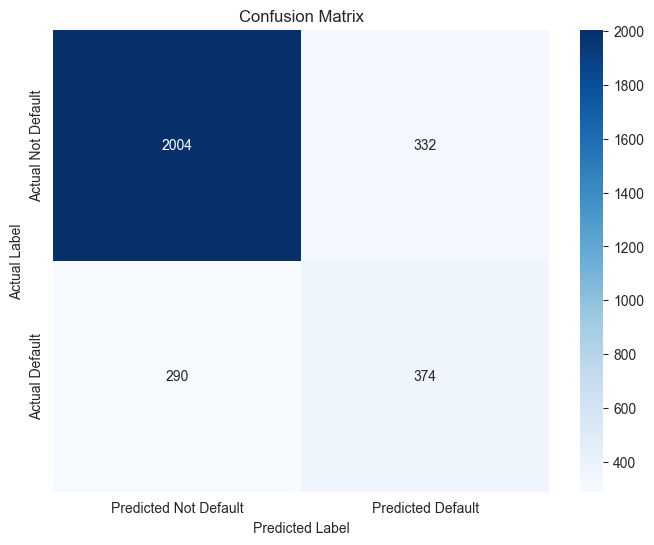

C:\Users\milkTeaGod\AppData\Local\Temp\ipykernel_4452\2422562452.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')


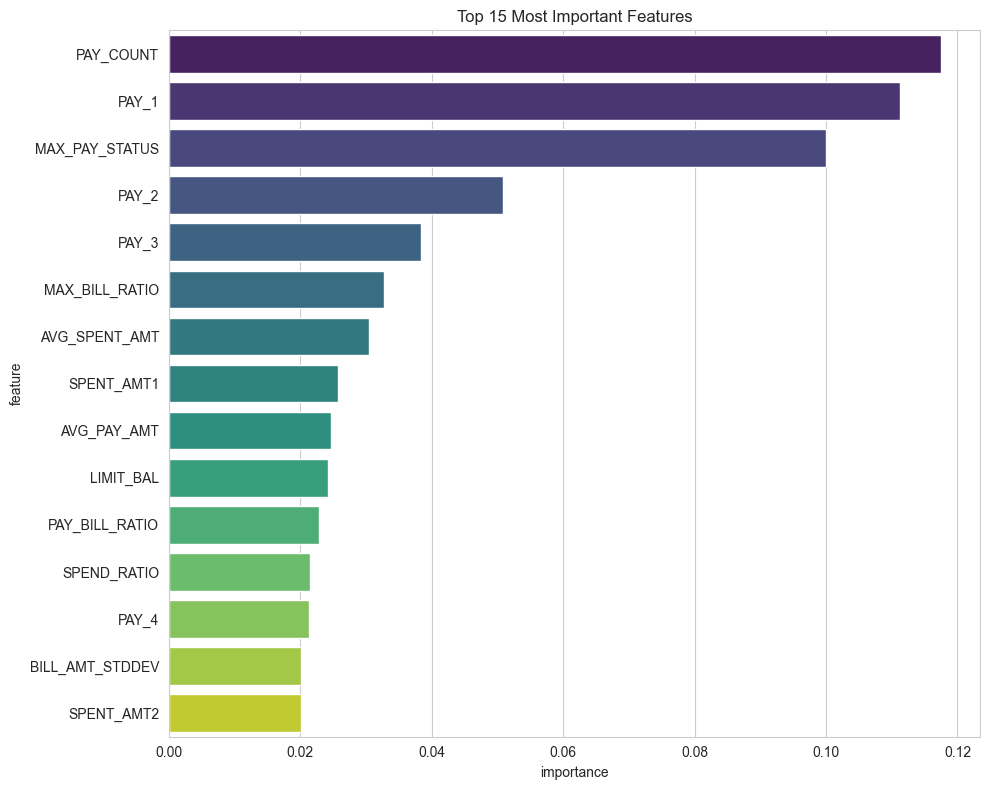

In [251]:


# --- 1. 数据加载与准备 ---
try:
    # 注意：在您的本地环境中，请将 'de_df.csv' 替换为文件的实际路径
    # 例如: df = pd.read_csv('C:/path/to/your/de_df.csv')
    file_path = 'de_df.csv' 
    df = pd.read_csv(file_path)
    
    # 检查并删除在保存CSV时可能产生的额外索引列
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
        
    print("成功加载 de_df.csv 数据集。")
    print(f"数据集维度: {df.shape}")

    # 定义目标变量和特征变量
    TARGET = 'default.payment.next.month'
    # 使用除了ID和目标之外的所有列作为模型的输入特征
    FEATURES = [col for col in df.columns if col not in ['ID', TARGET]]
    
    X = df[FEATURES]
    y = df[TARGET]

    # --- 2. 划分训练集和测试集 ---
    # 按80/20的比例划分数据
    # stratify=y 参数确保了训练集和测试集中的违约/未违约客户比例与原始数据集保持一致，这对于不平衡数据集非常重要
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42, stratify=y
    )
    print("\n已将数据划分为80%的训练集和20%的测试集。")
    print(f"训练集大小: {X_train.shape[0]} | 测试集大小: {X_test.shape[0]}")

    # --- 3. 模型训练 ---
    # 初始化随机森林分类器
    # class_weight='balanced' 是处理样本不平衡的关键，它会自动给样本量较少的类别（违约客户）更高的权重
    # n_estimators=150 是一个在性能和计算速度之间取得良好平衡的常用值
    # max_depth=10 用于限制每棵树的深度，有助于防止模型过拟合
    # n_jobs=-1 将使用所有可用的CPU核心来加速训练
    rf_model = RandomForestClassifier(
        n_estimators=200, 
        class_weight='balanced', 
        random_state=42, 
        n_jobs=-1,
        max_depth=10
    )

    print("\n开始训练随机森林模型...")
    # 使用训练数据来拟合（训练）模型
    rf_model.fit(X_train, y_train)
    print("模型训练完成。")

    # --- 4. 模型评估 ---
    # 使用训练好的模型在测试集上进行预测
    y_pred = rf_model.predict(X_test)
    # 预测每个客户违约的概率，用于计算AUC分数
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1] 

    print("\n--- 模型在测试集上的评估结果 ---")
    
    # 打印分类报告，包含精确率(precision)、召回率(recall)、F1分数(f1-score)
    print("\n分类报告 (Classification Report):")
    print(classification_report(y_test, y_pred, target_names=['Not Default (0)', 'Default (1)']))
    
    # 打印AUC分数，衡量模型整体的区分能力
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nAUC-ROC Score: {auc:.4f}")

    # 可视化混淆矩阵，直观展示模型的预测正确与错误的情况
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Not Default', 'Predicted Default'],
                yticklabels=['Actual Not Default', 'Actual Default'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- 5. 特征重要性分析 ---
    # 从训练好的模型中提取特征的重要性得分
    importances = rf_model.feature_importances_
    # 创建一个DataFrame来展示每个特征及其重要性得分
    feature_importance_df = pd.DataFrame({
        'feature': FEATURES,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    # 可视化最重要的15个特征
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
    plt.title('Top 15 Most Important Features')
    plt.tight_layout() # 调整布局以防止标签重叠
    plt.show()

except FileNotFoundError:
    print(f"错误：文件 '{file_path}' 未找到。请确保文件名和路径正确。")
except Exception as e:
    print(f"处理数据时发生错误: {e}")

In [236]:
de_df.max()

ID                            3.000000e+04
LIMIT_BAL                     1.000000e+06
SEX                           2.000000e+00
EDUCATION                     4.000000e+00
MARRIAGE                      3.000000e+00
AGE                           7.900000e+01
PAY_1                         8.000000e+00
PAY_2                         8.000000e+00
PAY_3                         8.000000e+00
PAY_4                         8.000000e+00
PAY_5                         8.000000e+00
PAY_6                         8.000000e+00
BILL_AMT1                     9.645110e+05
BILL_AMT2                     9.839310e+05
BILL_AMT3                     1.664089e+06
BILL_AMT4                     8.915860e+05
BILL_AMT5                     9.271710e+05
BILL_AMT6                     9.616640e+05
PAY_AMT1                      8.735520e+05
PAY_AMT2                      1.684259e+06
PAY_AMT3                      8.960400e+05
PAY_AMT4                      6.210000e+05
PAY_AMT5                      4.265290e+05
PAY_AMT6   

In [223]:
df[df["PAY_BILL_RATIO"]>=10]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SPENT_AMT1,SPENT_AMT2,SPENT_AMT3,SPENT_AMT4,SPENT_AMT5,AVG_BILL_AMT,AVG_SPENT_AMT,PAY_COUNT,MAX_PAY_STATUS,PAY_COUNT_0,AVG_PAY_AMT,SPEND_RATIO,PAY_BILL_RATIO,PAY_SPENT_RATIO,EXCEED_LIMIT_NUM,default.payment.next.month,HAD_AVG_BILL,HAD_AVG_SPENT
389,390,260000,1,1,1,30,-1,-1,-1,0,0,-1,1131,291,582,291,0,291,291,582,0,0,130291,651,1131,291,291,291,130000,431.000000,26400.8,0,0,2,21969.166667,0.101542,50.972544,0.832140,0,1,1,1
1011,1012,410000,2,1,1,31,-1,-1,2,2,-2,-2,2744,2041,630,-736,-1591,-2303,2051,5,266,266,253,6384,2754,1416,1632,1121,965,130.833333,1577.6,2,2,0,1537.500000,0.003848,11.751592,0.974582,0,0,1,1
2042,2043,330000,2,1,1,36,1,-2,-2,-1,-1,-1,0,0,0,1983,0,207,0,0,1983,0,207,49974,0,0,0,1983,0,365.000000,396.6,1,1,0,8694.000000,0.001202,23.819178,21.921331,0,0,1,1
2433,2434,100000,2,1,2,36,1,-1,-1,-2,-2,-2,0,780,0,0,0,0,780,0,0,7600,0,0,0,780,0,7600,0,130.000000,1676.0,1,1,0,1396.666667,0.016760,10.743590,0.833333,0,0,1,1
2596,2597,160000,2,2,2,27,-2,-2,-1,-1,-1,0,490,-85,5215,4115,3921,3421,3085,5300,1000,22200,2000,149763,3660,0,2100,22394,2500,2846.166667,6130.8,0,0,1,30558.000000,0.038317,10.736546,4.984341,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,27496,170000,1,2,1,57,-1,-1,-1,-1,0,-1,792,-2604,396,792,396,396,0,3396,792,0,396,396,3396,396,396,396,396,28.000000,996.0,0,0,1,830.000000,0.005859,29.642857,0.833333,0,1,1,1
27555,27556,360000,1,3,2,54,-2,-2,-2,-2,-2,-2,390,390,390,390,390,390,390,390,390,390,390,96702,390,390,390,390,390,390.000000,390.0,0,-2,0,16442.000000,0.001083,42.158974,42.158974,0,0,1,1
27564,27565,30000,1,4,1,53,-2,-2,-2,-2,-2,-2,1780,0,0,0,0,0,24437,0,0,0,0,0,26217,0,0,0,0,296.666667,5243.4,0,-2,0,4072.833333,0.174780,13.728652,0.776754,0,1,1,1
28122,28123,300000,2,1,1,37,0,-1,-1,-1,-2,-1,4476,2521,3529,-5364,-8943,4057,3017,4506,0,0,14000,12000,4972,3498,8893,3579,1000,46.000000,4388.4,0,0,1,5587.166667,0.014628,121.460145,1.273167,0,0,1,1


In [229]:
df.shape

(29989, 42)

In [230]:
df[df["EXCEED_LIMIT_NUM"]>0]["default.payment.next.month"].mean()

0.30094123632663444